**1. IMPORT LIBRARIES**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.stats import f_oneway, kruskal
from scipy.cluster.hierarchy import dendrogram, linkage

**2. LOAD AND INSPECT DATASET**

Shape: (5758, 8)
          Artist Name Sales Channel Visibility Level  \
0  Iretioluwa Jeffrey      Physical             High   
1       Esi Christian      Physical              Low   
2        Abdul Nathan        Online           Medium   
3        Usman Edward        Online             High   
4       Chima Allison      Physical             High   

   Artist Experience (Years)  Price (GHS)  Sales Volume  \
0                          8      2623.47            39   
1                         29      5831.69            71   
2                          3      2754.87            54   
3                          1       100.00            28   
4                         32      6273.44            55   

   Social Media Followers Sale Month  
0                  6123.0      April  
1                 12935.0   February  
2                 11136.0   February  
3                  5792.0    January  
4                  6769.0  September  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5758 en

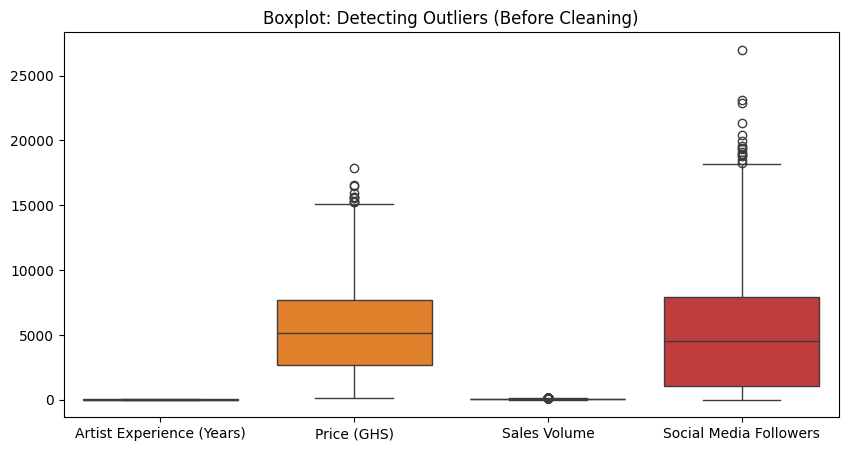

In [ ]:
df = pd.read_csv('/content/ghana_art_market.csv')
df.columns = df.columns.str.strip()

print("Shape:", df.shape)
print(df.head())
df.info()

# Duplicates
dup_counts = df['Artist Name'].value_counts()
print(f"Artists with duplicates: {(dup_counts > 1).sum()}")

# Missing values
print("Missing values:\n", df.isnull().sum())

# Outliers (before cleaning)
num_cols = ['Artist Experience (Years)','Price (GHS)','Sales Volume','Social Media Followers']
plt.figure(figsize=(10, 5))
sns.boxplot(data=df[num_cols])
plt.title("Boxplot: Detecting Outliers (Before Cleaning)")
plt.show()


In [ ]:
df.describe()

,Artist Experience (Years),Price (GHS),Sales Volume,Social Media Followers
count,5758.000000,5694.000000,5758.000000,5702.000000
mean,18.237061,5301.007734,45.928621,5004.040161
std,10.084147,3319.714061,24.092094,4283.397128
min,1.000000,100.000000,1.000000,0.000000
25%,10.000000,2719.257500,28.000000,1043.750000
50%,18.000000,5165.690000,43.000000,4499.500000
75%,27.000000,7682.102500,60.000000,7909.750000
max,35.000000,17857.820000,120.000000,26995.000000


**3. PRE-PROCESSING**

In [ ]:
cat_cols = ['Sale Month','Sales Channel','Visibility Level','Artist Name']
num_cols = ['Artist Experience (Years)','Price (GHS)','Sales Volume','Social Media Followers']

# Handle missing values
df[cat_cols] = df[cat_cols].fillna('Unknown')
df[num_cols] = df[num_cols].fillna(df[num_cols].median())


**3.1 Raw vs Transformed Distributions**

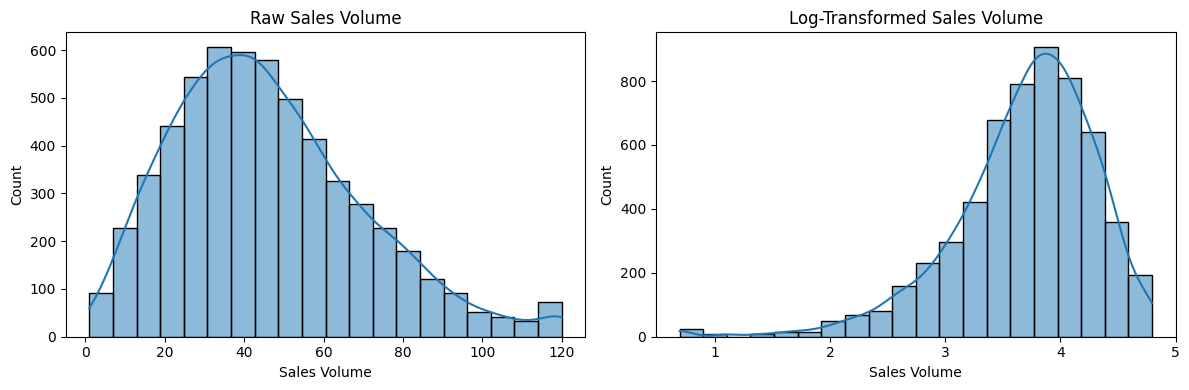

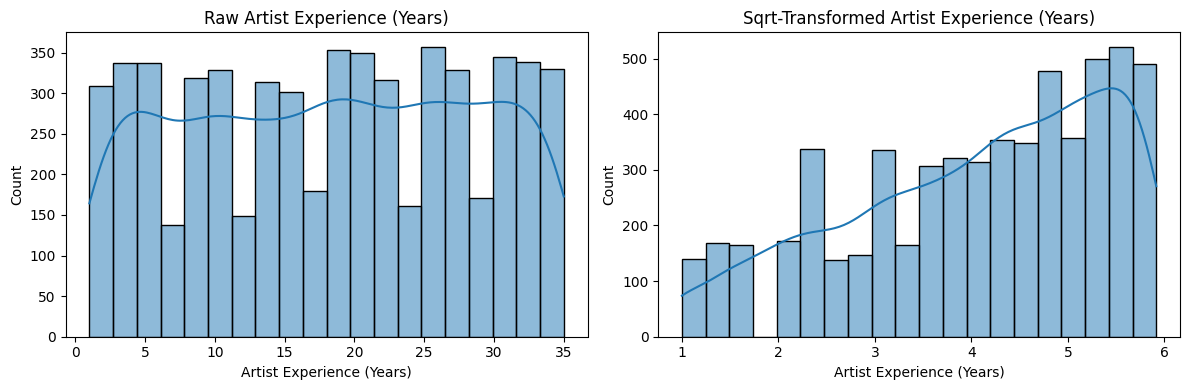

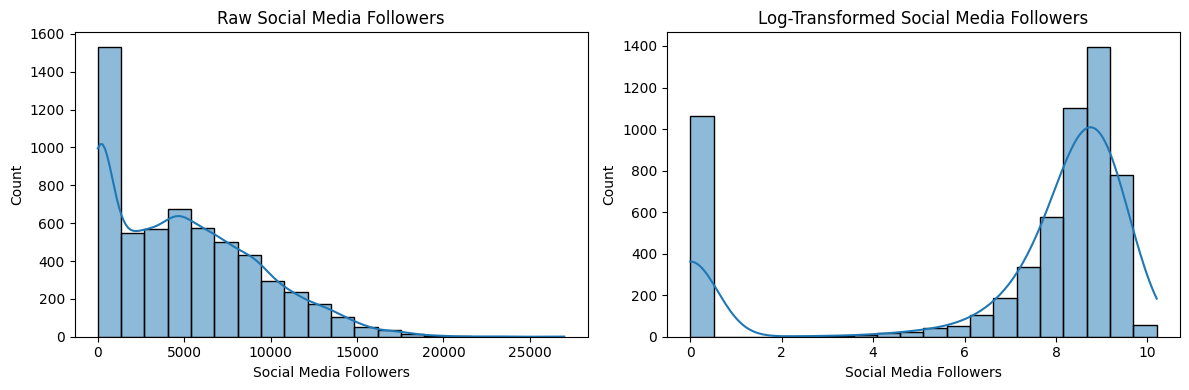

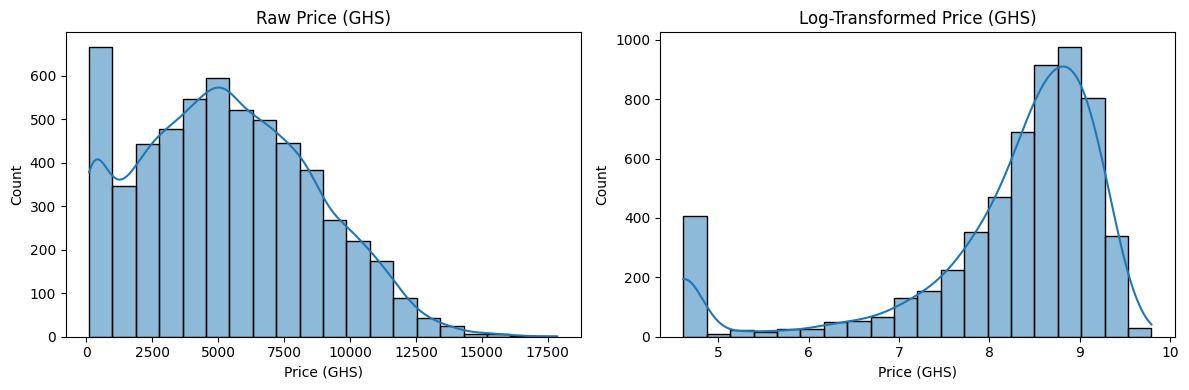

In [ ]:
transform_config = {
    'Sales Volume': 'log',
    'Artist Experience (Years)': 'sqrt',
    'Social Media Followers': 'log',
    'Price (GHS)': 'log'
}

for col, method in transform_config.items():
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    sns.histplot(df[col], kde=True, bins=20, ax=axes[0])
    axes[0].set_title(f"Raw {col}")

    if method == 'log':
        transformed = np.log1p(df[col]); trans_name = "Log"
    elif method == 'sqrt':
        transformed = np.sqrt(df[col]); trans_name = "Sqrt"
    else:
        transformed = df[col]; trans_name = "Raw"

    sns.histplot(transformed, kde=True, bins=20, ax=axes[1])
    axes[1].set_title(f"{trans_name}-Transformed {col}")

    plt.tight_layout()
    plt.show()


**3.2. APPLY TRANSFORMATIONS TO HANDLE SKEWNESS AND OUTLIERS**

In [ ]:
# Rationale: Financial and social data (Price, Sales, Followers) are often right-skewed.Log transformation (np.log1p) helps normalize these distributions, reduce the influence of extreme outliers, and make patterns more linear.

# Create log-transformed versions of key skewed features
df['Price_log'] = np.log1p(df['Price (GHS)'])
df['SalesVolume_log'] = np.log1p(df['Sales Volume'])
df['Followers_log'] = np.log1p(df['Social Media Followers'])

# Define the feature set for clustering and scale them to a common [0, 1] range
features = ['Artist Experience (Years)','Price_log','SalesVolume_log','Followers_log']
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

**4. EXPLORATORY DATA ANALYSIS (EDA)**

**4.1 Correlations**

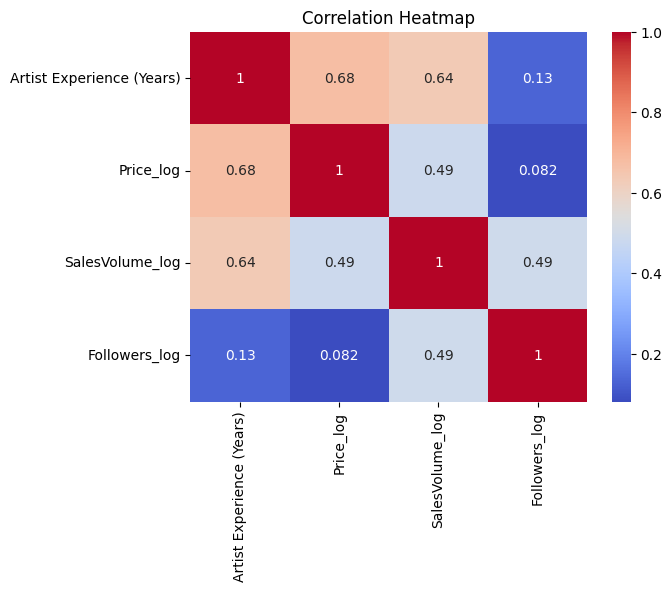

In [ ]:
sns.heatmap(df[features].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


In [ ]:
# Calculate the correlation matrix for the features we used
correlation_matrix = df[['Artist Experience (Years)', 'Price_log', 'SalesVolume_log', 'Followers_log']].corr(method='pearson')

# Display the matrix with 3 decimal places
print("Pearson Correlation Matrix:")
print(correlation_matrix.round(3))

Pearson Correlation Matrix:
                           Artist Experience (Years)  Price_log  \
Artist Experience (Years)                      1.000      0.676   
Price_log                                      0.676      1.000   
SalesVolume_log                                0.638      0.485   
Followers_log                                  0.133      0.082   

                           SalesVolume_log  Followers_log  
Artist Experience (Years)            0.638          0.133  
Price_log                            0.485          0.082  
SalesVolume_log                      1.000          0.491  
Followers_log                        0.491          1.000  


**4.2 Trends Over Time**

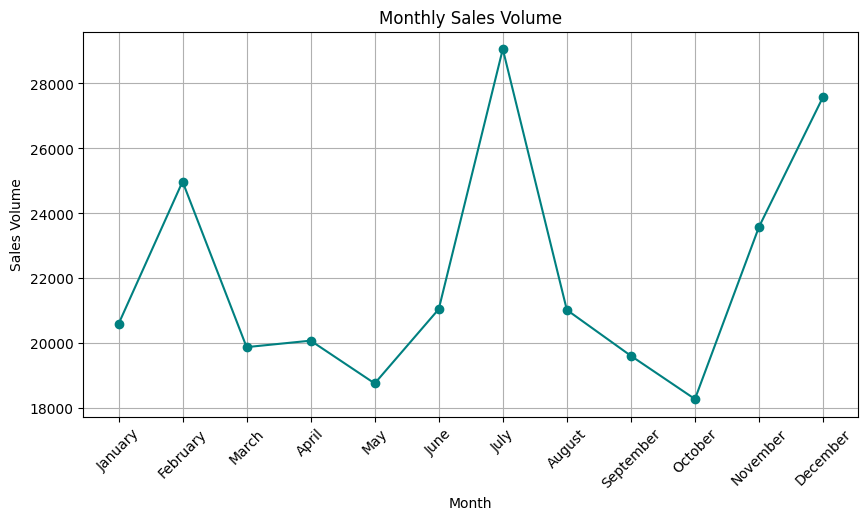

In [ ]:
monthly_order = ["January","February","March","April","May","June",
                 "July","August","September","October","November","December"]

monthly_sales = df.groupby('Sale Month')['Sales Volume'].sum().reindex(monthly_order)

plt.figure(figsize=(10,5))
plt.plot(monthly_sales.index, monthly_sales.values, marker='o', color='teal')
plt.title("Monthly Sales Volume")
plt.ylabel("Sales Volume")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

**4.3 Categorical Comparisons**

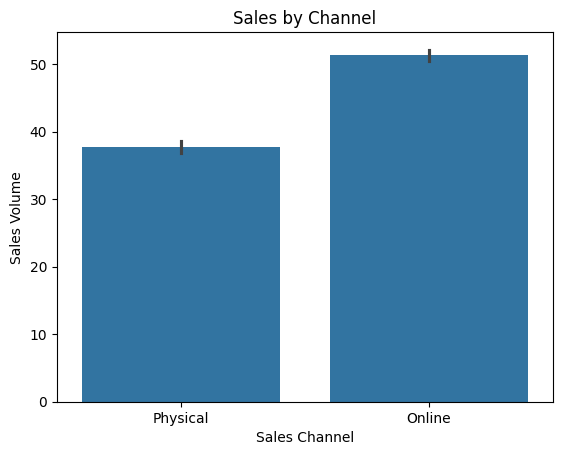

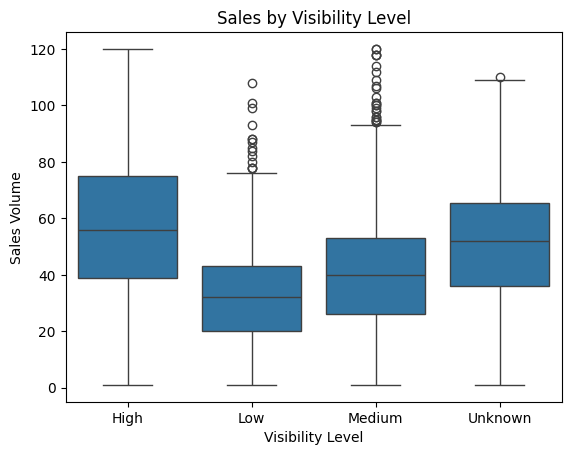

In [ ]:
sns.barplot(data=df, x='Sales Channel', y='Sales Volume')
plt.title("Sales by Channel")
plt.show()

sns.boxplot(data=df, x='Visibility Level', y='Sales Volume')
plt.title("Sales by Visibility Level")
plt.show()

**5. STATISTICAL SIGNIFICANCE TESTING**

In [ ]:
# Objective: Determine if key categorical factors significantly influence Sales Volume.We use both parametric (ANOVA) and non-parametric (Kruskal-Wallis) tests for robustness,and calculate effect size (Eta Squared) to measure practical importance.

print("\n" + "="*60)
print("STATISTICAL ANALYSIS: Drivers of Sales Volume")
print("="*60)

# Helper Function to Run Tests and Calculate Effect Size
def run_anova_kruskal(df, group_column, target_column='Sales Volume'):
    """
    Runs ANOVA and Kruskal-Wallis tests for a given grouping column.
    Calculates and returns results including effect size (Eta Squared).
    """
    groups = [group[target_column].values for _, group in df.groupby(group_column)]
    anova_result = f_oneway(*groups)
    kruskal_result = kruskal(*groups)

    grand_mean = df[target_column].mean()
    ss_between = sum([len(g) * (np.mean(g) - grand_mean)**2 for g in groups])
    ss_total = sum((df[target_column] - grand_mean)**2)
    eta_squared = ss_between / ss_total

    return anova_result, kruskal_result, eta_squared

alpha = 0.05

# 7.1. VISIBILITY LEVEL
print("\n1. EFFECT OF VISIBILITY LEVEL ON SALES VOLUME")
print("-" * 50)
anova_vis, kruskal_vis, eta_sq_vis = run_anova_kruskal(df, 'Visibility Level')

print(f"ANOVA Result:          F = {anova_vis.statistic:.2f}, p = {anova_vis.pvalue:.4f}")
print(f"Kruskal-Wallis Result: H = {kruskal_vis.statistic:.2f}, p = {kruskal_vis.pvalue:.4f}")
print(f"Effect Size (Eta²):    η² = {eta_sq_vis:.3f}")

if anova_vis.pvalue < alpha:
    print("Conclusion:            Visibility Level significantly affects Sales Volume (p < 0.05).")
else:
    print("Conclusion:            No significant effect found for Visibility Level (p > 0.05).")

if eta_sq_vis >= 0.14:
    vis_impact = "LARGE effect"
elif eta_sq_vis >= 0.06:
    vis_impact = "MEDIUM effect"
elif eta_sq_vis >= 0.01:
    vis_impact = "SMALL effect"
else:
    vis_impact = "NEGLIGIBLE effect"

print(f"Practical Significance: {vis_impact} ({eta_sq_vis:.1%} of variance explained).")


# 7.2. SALES CHANNEL
print("\n\n2. EFFECT OF SALES CHANNEL ON SALES VOLUME")
print("-" * 50)
anova_ch, kruskal_ch, eta_sq_ch = run_anova_kruskal(df, 'Sales Channel')

print(f"ANOVA Result:          F = {anova_ch.statistic:.2f}, p = {anova_ch.pvalue:.4f}")
print(f"Kruskal-Wallis Result: H = {kruskal_ch.statistic:.2f}, p = {kruskal_ch.pvalue:.4f}")
print(f"Effect Size (Eta²):    η² = {eta_sq_ch:.3f}")

if anova_ch.pvalue < alpha:
    print("Conclusion:            Sales Channel significantly affects Sales Volume (p < 0.05).")
else:
    print("Conclusion:            No significant effect found for Sales Channel (p > 0.05).")

if eta_sq_ch >= 0.14:
    ch_impact = "LARGE effect"
elif eta_sq_ch >= 0.06:
    ch_impact = "MEDIUM effect"
elif eta_sq_ch >= 0.01:
    ch_impact = "SMALL effect"
else:
    ch_impact = "NEGLIGIBLE effect"

print(f"Practical Significance: {ch_impact} ({eta_sq_ch:.1%} of variance explained).")


# 7.3. SUMMARY TABLE
print("\n3. SUMMARY COMPARISON OF FACTORS")
print("-" * 70)
print(f"{'Factor':<20} {'P-Value':<12} {'Effect Size (η²)':<18} {'Practical Impact':<20}")
print("-" * 70)
print(f"{'Visibility Level':<20} {anova_vis.pvalue:.4e}{'':<5} {eta_sq_vis:.3f}{'':<10} {vis_impact:<20}")
print(f"{'Sales Channel':<20} {anova_ch.pvalue:.4e}{'':<5} {eta_sq_ch:.3f}{'':<10} {ch_impact:<20}")
print("="*60)



STATISTICAL ANALYSIS: Drivers of Sales Volume

1. EFFECT OF VISIBILITY LEVEL ON SALES VOLUME
--------------------------------------------------
ANOVA Result:          F = 403.69, p = 0.0000
Kruskal-Wallis Result: H = 969.01, p = 0.0000
Effect Size (Eta²):    η² = 0.174
Conclusion:            Visibility Level significantly affects Sales Volume (p < 0.05).
Practical Significance: LARGE effect (17.4% of variance explained).


2. EFFECT OF SALES CHANNEL ON SALES VOLUME
--------------------------------------------------
ANOVA Result:          F = 471.68, p = 0.0000
Kruskal-Wallis Result: H = 415.12, p = 0.0000
Effect Size (Eta²):    η² = 0.076
Conclusion:            Sales Channel significantly affects Sales Volume (p < 0.05).
Practical Significance: MEDIUM effect (7.6% of variance explained).

3. SUMMARY COMPARISON OF FACTORS
----------------------------------------------------------------------
Factor               P-Value      Effect Size (η²)   Practical Impact    
---------------------

**6. FEATURE ENGINEERING**

In [ ]:
df['Sales_Efficiency'] = df['Price_log'] * df['SalesVolume_log']

**7. CLUSTERING ANALYSIS**

**7.1. DETERMINE THE OPTIMAL NUMBER OF CLUSTERS (K) - ELBOW METHOD**

Running Elbow Method to find optimal number of clusters...
  - k = 1: Inertia = 1591.54
  - k = 2: Inertia = 1015.53
  - k = 3: Inertia = 548.86
  - k = 4: Inertia = 419.42
  - k = 5: Inertia = 309.31
  - k = 6: Inertia = 274.92
  - k = 7: Inertia = 218.75
  - k = 8: Inertia = 197.07
  - k = 9: Inertia = 185.17
  - k = 10: Inertia = 173.91


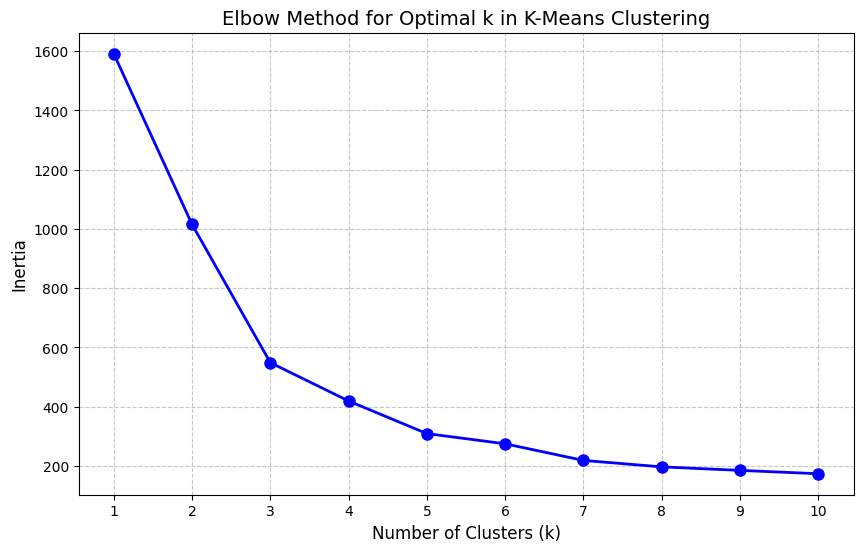


Suggested optimal k (based on maximum curvature): 2


In [ ]:
X = df[features].values

print("Running Elbow Method to find optimal number of clusters...")
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    print(f"  - k = {k}: Inertia = {kmeans.inertia_:.2f}")

# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.title('Elbow Method for Optimal k in K-Means Clustering', fontsize=14)
plt.xticks(k_range)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Automated elbow detection (simple gradient method)
gradients = np.diff(inertia)
optimal_k = gradients.argmin() + 2  # +2 because diff reduces length by 1, and k starts at 2
print(f"\nSuggested optimal k (based on maximum curvature): {optimal_k}")

**7.2 Apply K mean**

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42).fit(X)
df['Cluster'] = kmeans.labels_

**7.3 Validation & PCA Visualization**

Silhouette Score: 0.459


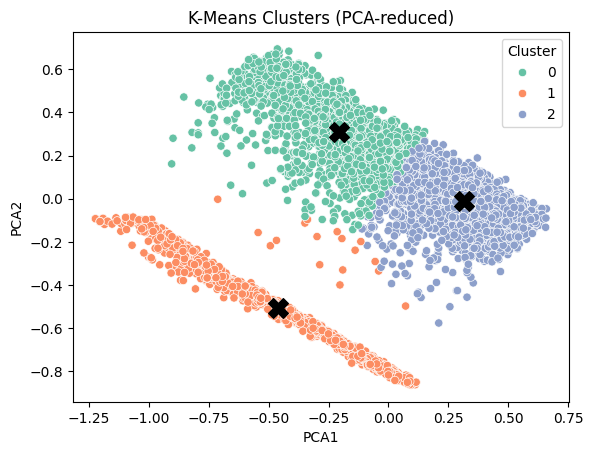

In [ ]:
print("Silhouette Score:", round(silhouette_score(X, df['Cluster']), 3))

pca = PCA(n_components=2)
df[['PCA1','PCA2']] = pca.fit_transform(X)

sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster', palette='Set2')
plt.scatter(pca.transform(kmeans.cluster_centers_)[:,0],
            pca.transform(kmeans.cluster_centers_)[:,1],
            c='black', s=200, marker='X')
plt.title("K-Means Clusters (PCA-reduced)")
plt.show()

**7.4. Cluster Profiling And Intepretation**

In [ ]:
print("="*65)
print("CLUSTER PROFILES (Based on Scaled Features used for Clustering)")
print("="*65)

# Use the EXISTING 'features' list that was used for clustering
cluster_profile = df.groupby('Cluster')[features].mean().round(3)

# Get the most common Visibility Level for business context
cluster_profile['Most Common Visibility'] = df.groupby('Cluster')['Visibility Level'].agg(lambda x: x.mode()[0])

# Add cluster sizes and percentages
cluster_sizes = df['Cluster'].value_counts().sort_index()
cluster_profile['Size'] = cluster_sizes.values
cluster_profile['% of Market'] = (cluster_sizes.values / len(df) * 100).round(1)

print(cluster_profile)

print("\n" + "="*65)
print("BUSINESS INTERPRETATION")
print("="*65)

# Create a clear interpretation based on the scaled values (0 to 1)
for cluster_id in sorted(df['Cluster'].unique()):
    profile = cluster_profile.loc[cluster_id]

    print(f"\nCLUSTER {cluster_id} - {profile['Most Common Visibility']} Visibility ({profile['Size']} artists, {profile['% of Market']}%):")

    # Interpret each feature based on its scaled value
    # Price_log
    if profile['Price_log'] > 0.7:
        price_text = "HIGH PRICE"
    elif profile['Price_log'] > 0.4:
        price_text = "MEDIUM PRICE"
    else:
        price_text = "LOW PRICE"

    # SalesVolume_log
    if profile['SalesVolume_log'] > 0.7:
        sales_text = "HIGH SALES VOLUME"
    elif profile['SalesVolume_log'] > 0.4:
        sales_text = "MEDIUM SALES VOLUME"
    else:
        sales_text = "LOW SALES VOLUME"

    # Followers_log
    if profile['Followers_log'] > 0.7:
        followers_text = "HIGH FOLLOWER COUNT"
    elif profile['Followers_log'] > 0.4:
        followers_text = "MEDIUM FOLLOWER COUNT"
    else:
        followers_text = "LOW FOLLOWER COUNT"

    # Artist Experience (Years)
    if profile['Artist Experience (Years)'] > 0.7:
        exp_text = "HIGHLY EXPERIENCED"
    elif profile['Artist Experience (Years)'] > 0.4:
        exp_text = "MODERATELY EXPERIENCED"
    else:
        exp_text = "LOW EXPERIENCE"

    print(f"   • This group represents artists with {exp_text}, {price_text}, {sales_text}, and {followers_text}.")

print("\n" + "="*65)
print("SCALE: 0 = Lowest value in dataset, 1 = Highest value in dataset")
print("="*65)

CLUSTER PROFILES (Based on Scaled Features used for Clustering)
         Artist Experience (Years)  Price_log  SalesVolume_log  Followers_log  \
Cluster                                                                         
0                            0.219      0.511            0.670          0.816   
1                            0.435      0.653            0.602          0.005   
2                            0.728      0.816            0.820          0.833   

        Most Common Visibility  Size  % of Market  
Cluster                                            
0                       Medium  1875         32.6  
1                         High  1082         18.8  
2                         High  2801         48.6  

BUSINESS INTERPRETATION

CLUSTER 0 - Medium Visibility (1875 artists, 32.6%):
   • This group represents artists with LOW EXPERIENCE, MEDIUM PRICE, MEDIUM SALES VOLUME, and HIGH FOLLOWER COUNT.

CLUSTER 1 - High Visibility (1082 artists, 18.8%):
   • This group represe

**7.5 Hierarchical Clustering (Clustering Alternative)**

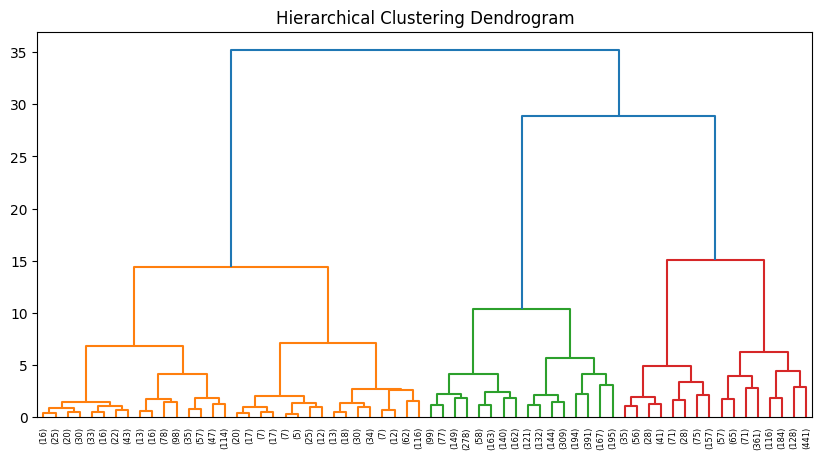

In [ ]:
plt.figure(figsize=(10,5))
dendrogram(linkage(X, method="ward"), truncate_mode="level", p=5)
plt.title("Hierarchical Clustering Dendrogram")
plt.show()


**8. Artist-Level Insights**

In [ ]:
# 9.1 Artist-level cluster summary
artist_cluster_summary = (
    df.groupby(['Artist Name', 'Cluster'])
      .agg({
          'Sales Volume': 'sum',             # overall market impact
          'Price (GHS)': 'mean',             # market positioning
          'Sales_Efficiency': 'mean',        # efficiency ratio
          'Social Media Followers': 'max'    # visibility
      })
      .reset_index()
)

# Remove placeholder artists
artist_summary_plot = artist_cluster_summary[artist_cluster_summary['Artist Name'] != 'Unknown']


**8.2 Full Artist Ranking (All Artists)**

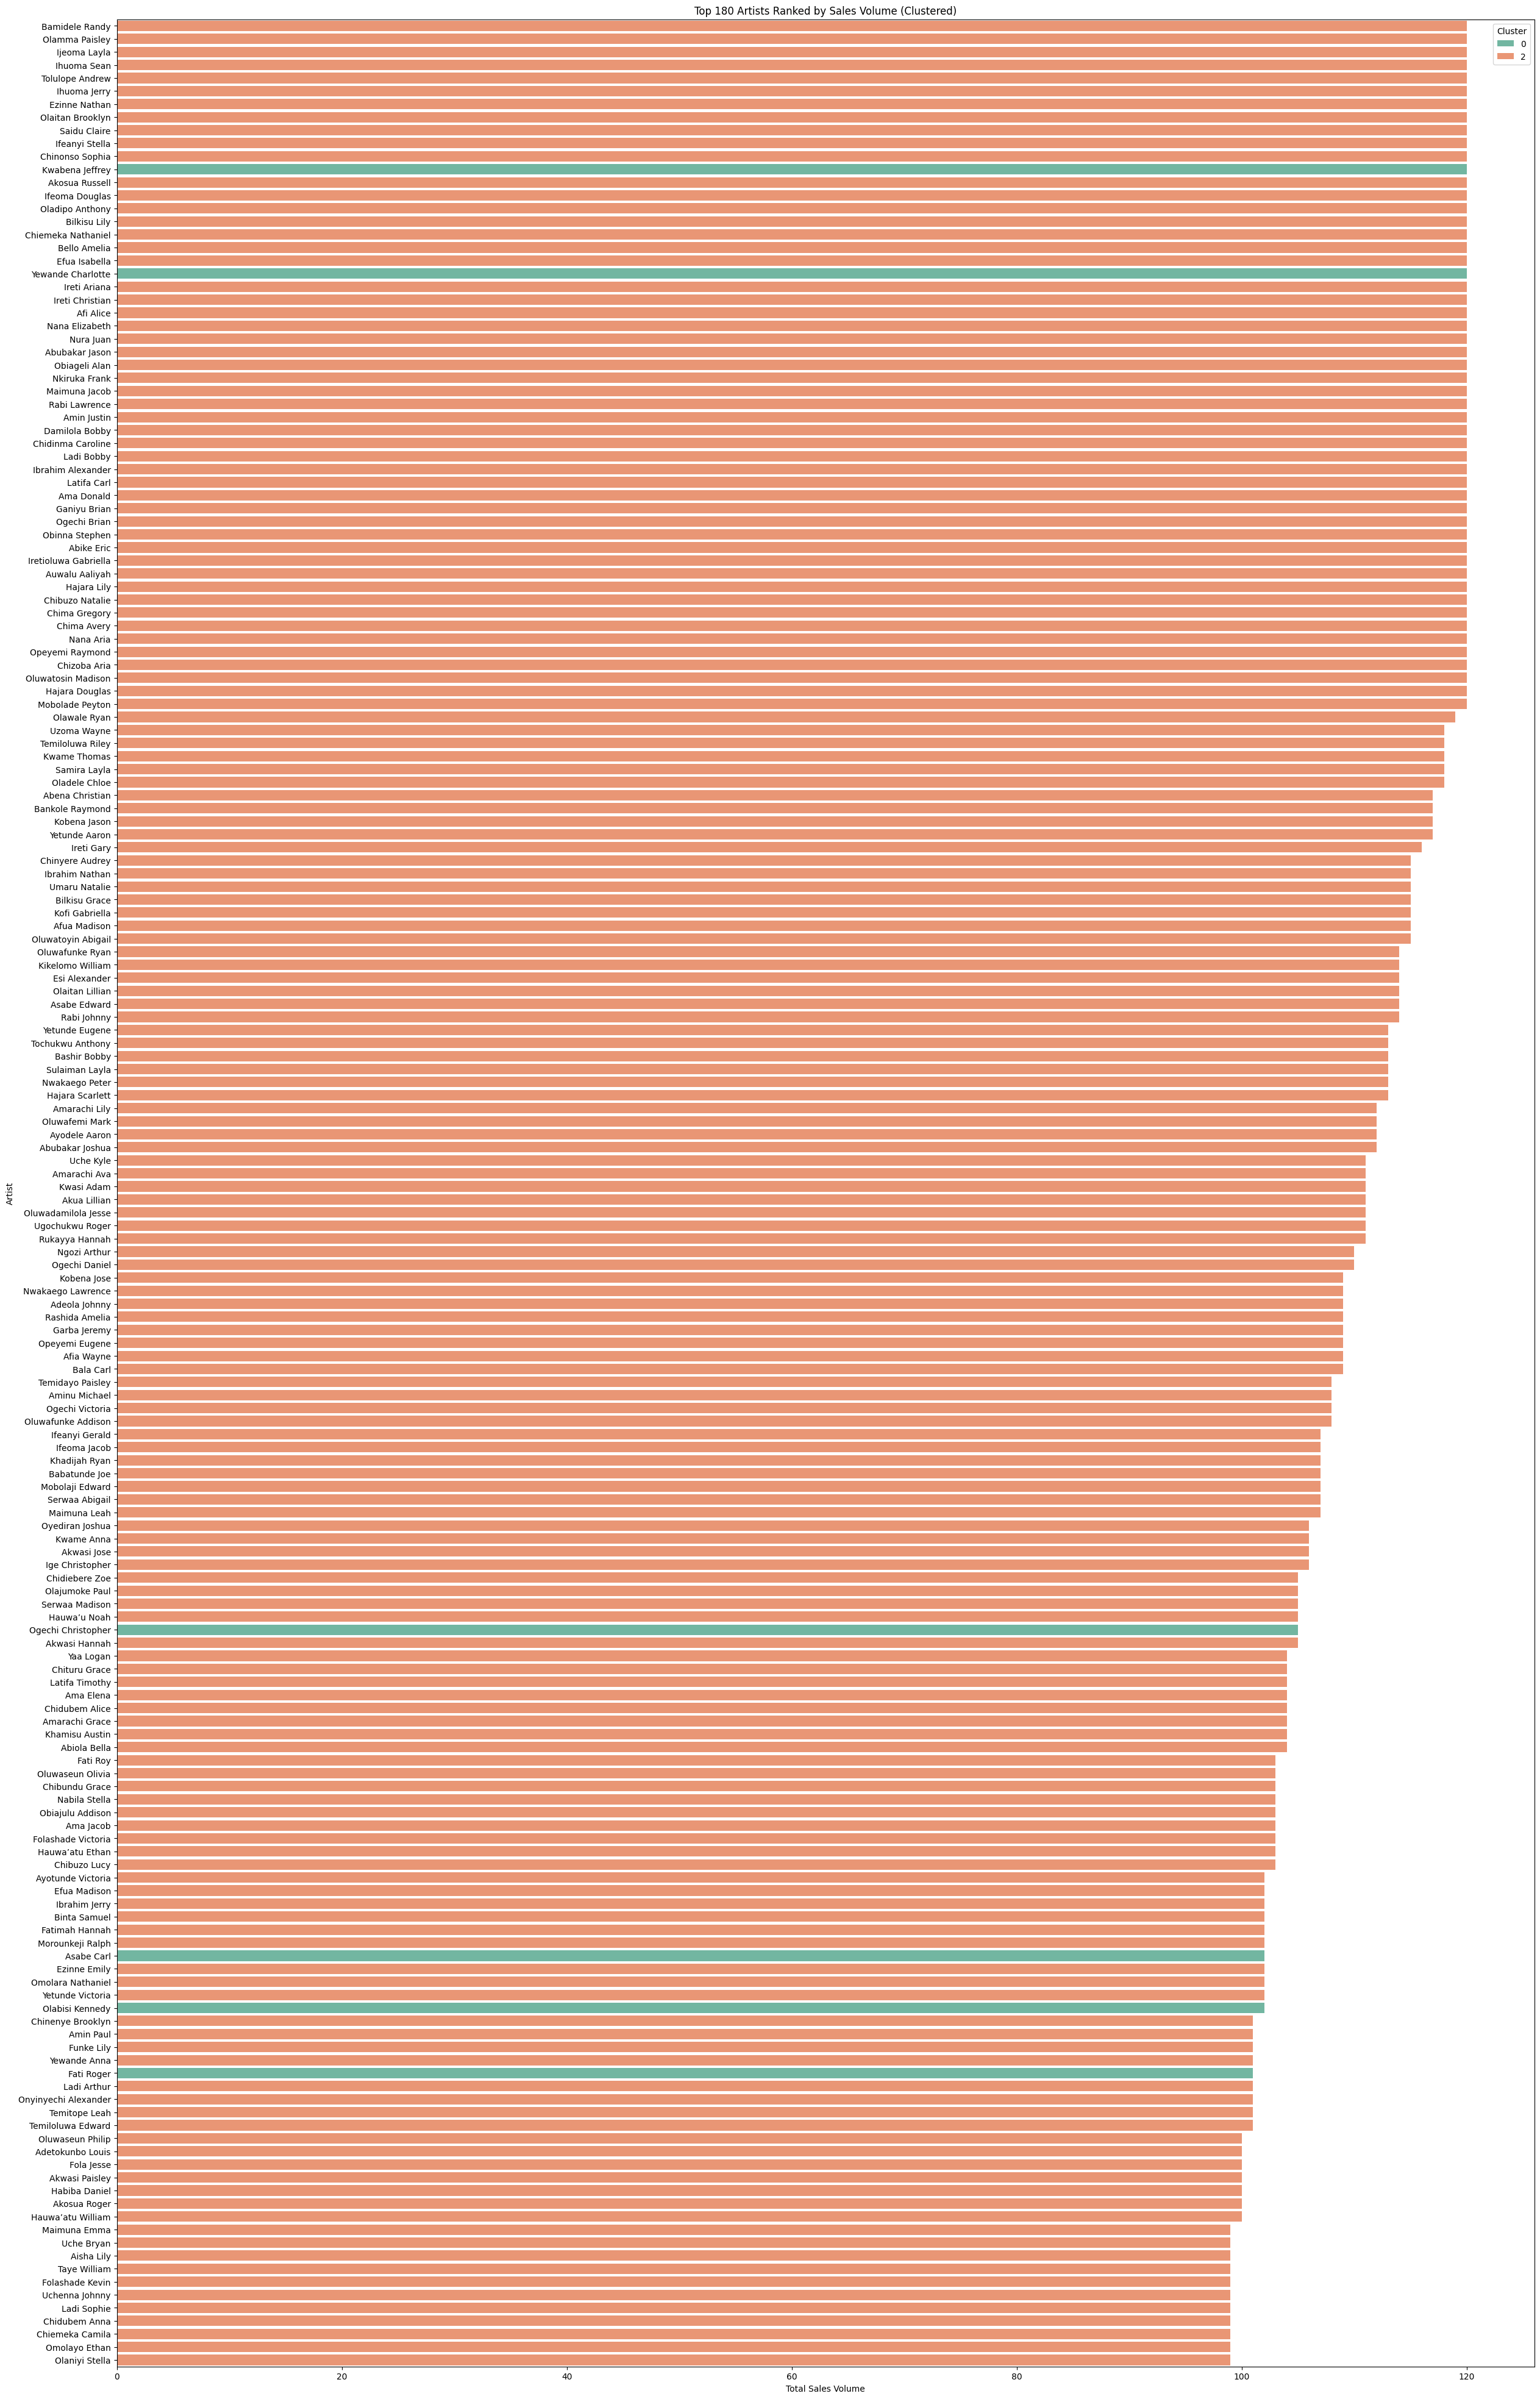

In [ ]:
# Rank artists by Sales Volume (descending)
top180_artists = (
    artist_summary_plot
    .sort_values('Sales Volume', ascending=False)
    .head(180)   # keep only top 180
)

# Plot only Top 180
plt.figure(figsize=(30, 50))
sns.barplot(
    data=top180_artists,
    x='Sales Volume', y='Artist Name', hue='Cluster',
    dodge=False, palette='Set2'
)
plt.xlabel("Total Sales Volume")
plt.ylabel("Artist")
plt.title("Top 180 Artists Ranked by Sales Volume (Clustered)")
plt.show()


**8.3 Compact Artist Ranking (Top 30)**

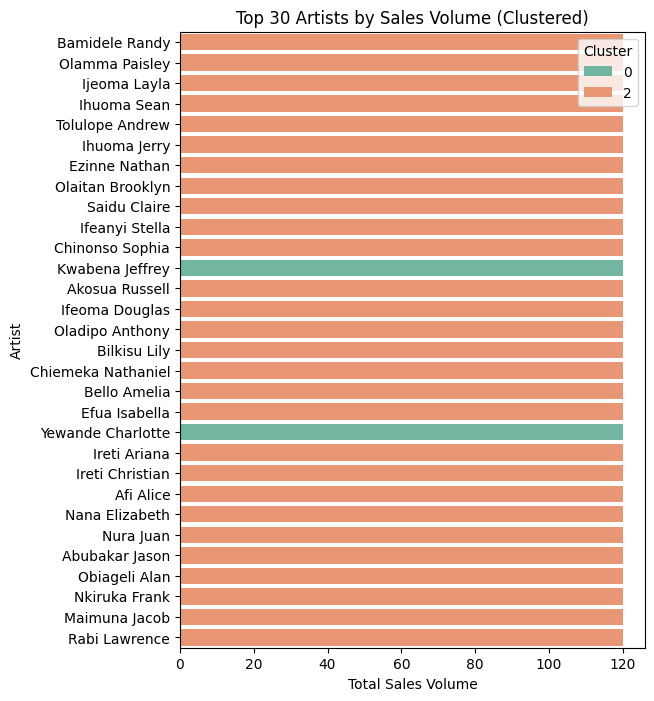

In [ ]:
plt.figure(figsize=(6, 8))
sns.barplot(
    data=artist_summary_plot.sort_values('Sales Volume', ascending=False).head(30),
    x='Sales Volume', y='Artist Name', hue='Cluster',
    dodge=False, palette='Set2'
)
plt.xlabel("Total Sales Volume")
plt.ylabel("Artist")
plt.title("Top 30 Artists by Sales Volume (Clustered)")
plt.show()


**8.4 Ranking Tables (Top 10 by Key Metrics)**

In [ ]:
top_by_volume = artist_summary_plot.groupby("Artist Name")["Sales Volume"].sum().sort_values(ascending=False).head(10)
top_by_price = artist_summary_plot.groupby("Artist Name")["Price (GHS)"].mean().sort_values(ascending=False).head(10)
top_by_followers = artist_summary_plot.groupby("Artist Name")["Social Media Followers"].max().sort_values(ascending=False).head(10)
top_by_efficiency = artist_summary_plot.groupby("Artist Name")["Sales_Efficiency"].mean().sort_values(ascending=False).head(10)

print("\nTop 10 Artists by Sales Volume:\n", top_by_volume)
print("\nTop 10 Artists by Average Price:\n", top_by_price)
print("\nTop 10 Artists by Followers:\n", top_by_followers)
print("\nTop 10 Artists by Sales Efficiency:\n", top_by_efficiency)



Top 10 Artists by Sales Volume:
 Artist Name
Bamidele Randy      120
Olamma Paisley      120
Ijeoma Layla        120
Ihuoma Sean         120
Tolulope Andrew     120
Ihuoma Jerry        120
Ezinne Nathan       120
Olaitan Brooklyn    120
Saidu Claire        120
Ifeanyi Stella      120
Name: Sales Volume, dtype: int64

Top 10 Artists by Average Price:
 Artist Name
Olaniyi Stella          17857.82
Sulaiman Austin         16586.10
Rukayya Ella            16486.22
Nwakaego Lawrence       15984.42
Habibatu Logan          15650.61
Ifeoluwa Jordan         15610.60
Oluwadamilola Claire    15594.87
Olamma Ronald           15324.09
Ifeoluwa Layla          15241.39
Ifeoma Amelia           15220.69
Name: Price (GHS), dtype: float64

Top 10 Artists by Followers:
 Artist Name
Iretioluwa Gabriella    26995.0
Fati Roger              23111.0
Chinonso Sophia         22885.0
Rukayya Samuel          21340.0
Chima Avery             20390.0
Maimuna Emma            19931.0
Ifeoluwa Julia          19602.0
Nab

**9. EXECUTIVE SUMMARY**

In [ ]:
print("="*80)
print("EXECUTIVE SUMMARY: Ghana Art Market Analysis")
print("="*80)

print("\n KEY FINDINGS:")
print(f"   • Market Segments: {len(df['Cluster'].unique())} distinct artist clusters identified")
print(f"   • Primary Sales Driver: Visibility Level (η² = {eta_sq_vis:.3f})")
print(f"   • Secondary Sales Driver: Sales Channel (η² = {eta_sq_ch:.3f})")

print("\n RECOMMENDATIONS:")
print("   1. Prioritize visibility-building activities (marketing, social media)")
print("   2. Develop cluster-specific strategies:")

# REUSE THE PROFILING LOGIC HERE to ensure consistency
cluster_profile = df.groupby('Cluster')[features].mean().round(3)
cluster_sizes = df['Cluster'].value_counts().sort_index()

for cluster_id in sorted(df['Cluster'].unique()):
    profile = cluster_profile.loc[cluster_id]
    size_percent = (cluster_sizes[cluster_id] / len(df) * 100)

    # The EXACT SAME interpretation logic from Section 7.4
    if profile['Price_log'] > 0.7: price_text = "HIGH PRICE"
    elif profile['Price_log'] > 0.4: price_text = "MEDIUM PRICE"
    else: price_text = "LOW PRICE"

    if profile['SalesVolume_log'] > 0.7: sales_text = "HIGH SALES VOLUME"
    elif profile['SalesVolume_log'] > 0.4: sales_text = "MEDIUM SALES VOLUME"
    else: sales_text = "LOW SALES VOLUME"

    if profile['Followers_log'] > 0.7: followers_text = "HIGH FOLLOWER COUNT"
    elif profile['Followers_log'] > 0.4: followers_text = "MEDIUM FOLLOWER COUNT"
    else: followers_text = "LOW FOLLOWER COUNT"

    if profile['Artist Experience (Years)'] > 0.7: exp_text = "HIGHLY EXPERIENCED"
    elif profile['Artist Experience (Years)'] > 0.4: exp_text = "MODERATELY EXPERIENCED"
    else: exp_text = "LOW EXPERIENCE"

    print(f"      - Cluster {cluster_id} ({size_percent:.1f}%): {exp_text}, {price_text}, {sales_text}, {followers_text}.")

print("\n   3. Analyze top-performing sales channels for investment")
print("   4. Use cluster profiles to guide artist development and positioning")

print(f"\n DATA QUALITY: Analysis based on {len(df)} records with complete preprocessing")
print("   including outlier handling, missing value imputation, and feature scaling.")
print("="*80)

EXECUTIVE SUMMARY: Ghana Art Market Analysis

 KEY FINDINGS:
   • Market Segments: 3 distinct artist clusters identified
   • Primary Sales Driver: Visibility Level (η² = 0.174)
   • Secondary Sales Driver: Sales Channel (η² = 0.076)

 RECOMMENDATIONS:
   1. Prioritize visibility-building activities (marketing, social media)
   2. Develop cluster-specific strategies:
      - Cluster 0 (32.6%): LOW EXPERIENCE, MEDIUM PRICE, MEDIUM SALES VOLUME, HIGH FOLLOWER COUNT.
      - Cluster 1 (18.8%): MODERATELY EXPERIENCED, MEDIUM PRICE, MEDIUM SALES VOLUME, LOW FOLLOWER COUNT.
      - Cluster 2 (48.6%): HIGHLY EXPERIENCED, HIGH PRICE, HIGH SALES VOLUME, HIGH FOLLOWER COUNT.

   3. Analyze top-performing sales channels for investment
   4. Use cluster profiles to guide artist development and positioning

 DATA QUALITY: Analysis based on 5758 records with complete preprocessing
   including outlier handling, missing value imputation, and feature scaling.


**10. FOR POWER BI**

In [ ]:
# Create the artist-level summary table
artist_summary_df = df.groupby(['Artist Name', 'Cluster', 'Visibility Level']).agg(
    Total_Sales_Volume=('Sales Volume', 'sum'),
    Average_Price=('Price (GHS)', 'mean'),
    Max_Followers=('Social Media Followers', 'max'),
    Sales_Efficiency=('Sales_Efficiency', 'mean')
).reset_index()

In [ ]:
# Download the artist summary dataframe as a CSV for Power bi
from google.colab import files

artist_summary_df.to_csv('ghana_artist_summary.csv', index=False)
files.download('ghana_artist_summary.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>